In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from xgboost import XGBRegressor
import lightgbm as lgb

In [2]:
# Load & Preprocess Data
# change path here to your file location
df = pd.read_csv(r"D:\AI Projects\ML Projects\Makaan_Properties_Buy_Dataset.csv", encoding="latin1")
print(df.columns)

Index(['Property_Name', 'Property_id', 'Property_type', 'Property_status',
       'Price_per_unit_area', 'Posted_On', 'Project_URL', 'builder_id',
       'Builder_name', 'Property_building_status', 'City_id', 'City_name',
       'No_of_BHK', 'Locality_ID', 'Locality_Name', 'Longitude', 'Latitude',
       'Price', 'Size', 'Sub_urban_ID', 'Sub_urban_name', 'description',
       'is_furnished', 'listing_domain_score', 'is_plot', 'is_RERA_registered',
       'is_Apartment', 'is_ready_to_move', 'is_commercial_Listing',
       'is_PentaHouse', 'is_studio', 'Listing_Category'],
      dtype='object')


In [3]:
# Drop rows where price or size missing
df = df.dropna(subset=['Price', 'Size'])

# Fill missing values in other columns
df.fillna(method='ffill', inplace=True)

C:\Users\ittyavira\AppData\Local\Temp\ipykernel_17512\442572260.py:5: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df.fillna(method='ffill', inplace=True)


In [4]:
# Feature engineering: BHK and Price per sqft
if 'propertyType' in df.columns:
    df['BHK'] = df['propertyType'].str.extract('(\d+)').astype(float)
else:
    df['BHK'] = 0  # fallback if propertyType not present

df['Price_per_sqft'] = df['Price'] / (df['Size'] + 1)

In [5]:
# Select features & target
feature_cols = ['Size', 'BHK', 'Price_per_sqft', 'City_name', 'is_furnished']
X = df[feature_cols]
y = df['Price']

# Identify categorical & numeric columns
cat_cols = ['City_name', 'is_furnished']
num_cols = ['Size', 'BHK', 'Price_per_sqft']

# Preprocessor
preprocessor = ColumnTransformer([
    ('cat', OneHotEncoder(handle_unknown='ignore'), cat_cols),
    ('num', StandardScaler(), num_cols)
])

In [6]:
# Train and split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

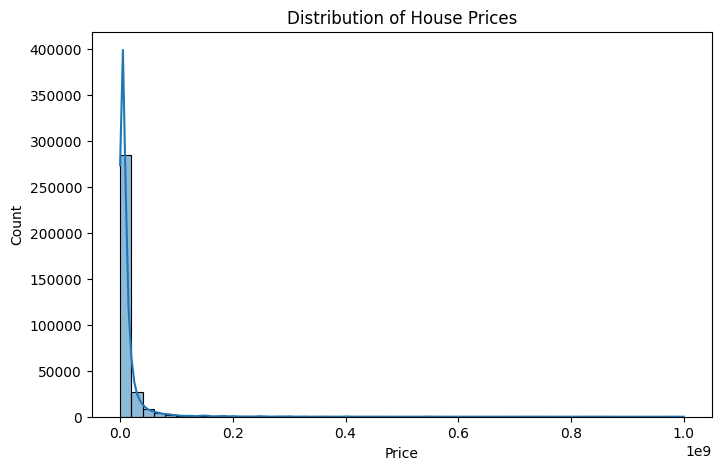

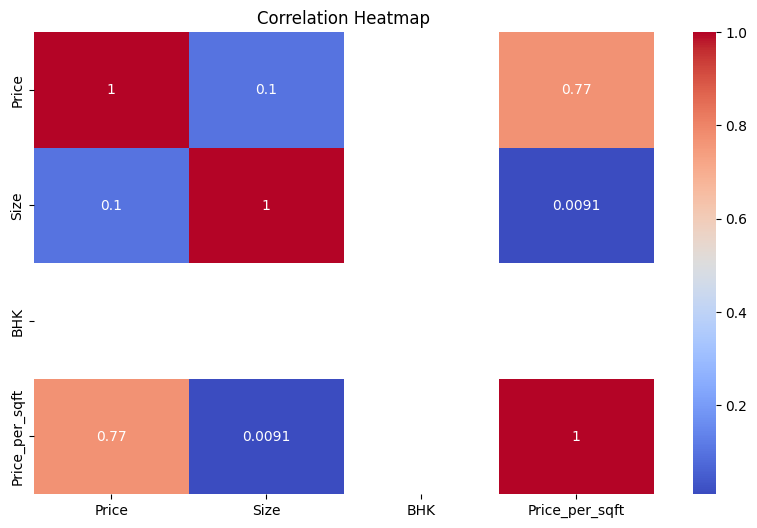

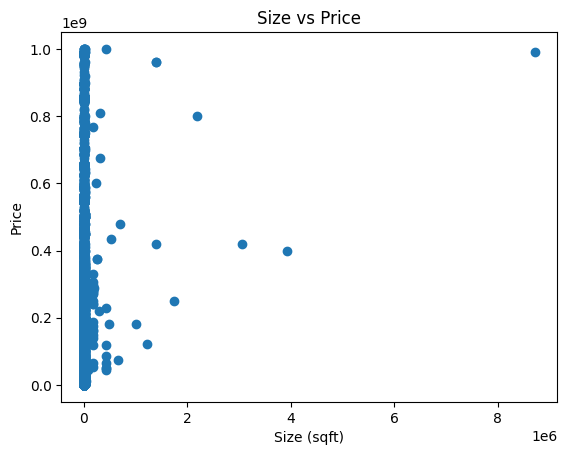

In [7]:
# Exploratory Data Analysis
plt.figure(figsize=(8,5))
sns.histplot(df['Price'], bins=50, kde=True)
plt.title('Distribution of House Prices')
plt.show()

plt.figure(figsize=(10,6))
sns.heatmap(df[['Price','Size','BHK','Price_per_sqft']].corr(), annot=True, cmap='coolwarm')
plt.title('Correlation Heatmap')
plt.show()

if 'location' in df.columns:
    city_avg = df.groupby('location')['Price'].mean().sort_values()
    city_avg.plot(kind='bar', figsize=(12,5), title='Average Price by Location')
    plt.show()

plt.scatter(df['Size'], df['Price'])
plt.xlabel('Size (sqft)')
plt.ylabel('Price')
plt.title('Size vs Price')
plt.show()

In [8]:
# Model Training & Evaluation
models = {
    "Linear Regression": LinearRegression(),
    "Random Forest": RandomForestRegressor(n_estimators=100, random_state=42),
    "XGBoost": XGBRegressor(objective='reg:squarederror', random_state=42),
    "LightGBM": lgb.LGBMRegressor(random_state=42)
}

for name, model in models.items():
    pipe = Pipeline([('pre', preprocessor), ('model', model)])
    pipe.fit(X_train, y_train)
    preds = pipe.predict(X_test)
    rmse = np.sqrt(mean_squared_error(y_test, preds))
    mae = mean_absolute_error(y_test, preds)
    r2 = r2_score(y_test, preds)
    print(f"\n===== {name} =====")
    print(f"RMSE: {rmse:.2f}, MAE: {mae:.2f}, R²: {r2:.2f}")


===== Linear Regression =====
RMSE: 24969792.49, MAE: 11758858.04, R²: 0.69

===== Random Forest =====
RMSE: 1671242.46, MAE: 67223.40, R²: 1.00

===== XGBoost =====
RMSE: 9431353.31, MAE: 847860.44, R²: 0.96
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.039737 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 532
[LightGBM] [Info] Number of data points in the train set: 265676, number of used features: 13
[LightGBM] [Info] Start training from score 15423817.246165


C:\Users\ittyavira\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(



===== LightGBM =====
RMSE: 8404857.31, MAE: 867932.73, R²: 0.97


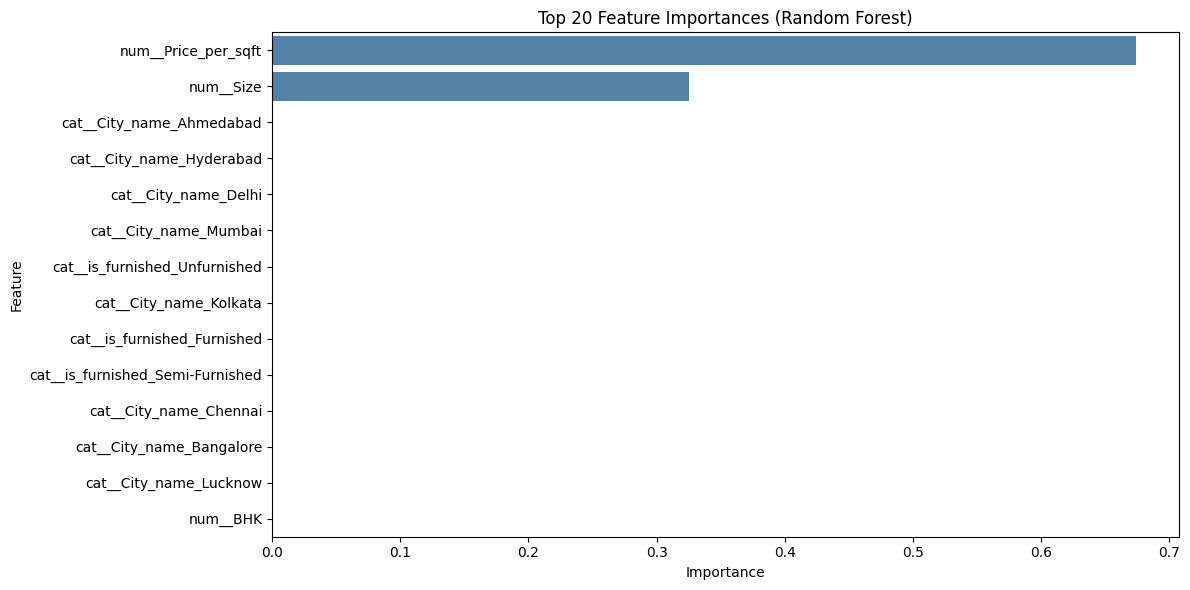

In [9]:
# Fit Random Forest with pipeline
rf = RandomForestRegressor(n_estimators=200, random_state=42)
rf_pipe = Pipeline([
    ('pre', preprocessor),
    ('model', rf)
])
rf_pipe.fit(X_train, y_train)

# Get feature names and importances
feature_names = rf_pipe.named_steps['pre'].get_feature_names_out()
importances = rf_pipe.named_steps['model'].feature_importances_

feat_imp = pd.DataFrame({
    'Feature': feature_names,
    'Importance': importances
}).sort_values('Importance', ascending=False)

# Plot Top 20
plt.figure(figsize=(12, 6))
sns.barplot(x='Importance', y='Feature', data=feat_imp.head(20), color='steelblue')
plt.title('Top 20 Feature Importances (Random Forest)')
plt.tight_layout()
plt.show()